In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

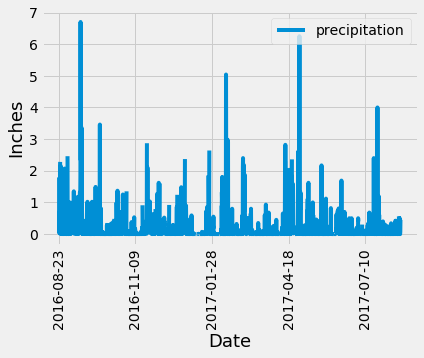

In [10]:
#plt.figure(figsize=(25,18))
# Design a query to retrieve the last 12 months of precipitation data and plot the results

result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
result = result[0]

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(result, "%Y-%m-%d") - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

#precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
#precipitation_df = precipitation_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(rot=90)
plt.legend(loc='upper right')
plt.xlabel("Date",fontsize = 18, color = 'black')
plt.ylabel("Inches",fontsize=18, color='black')
plt.savefig("Images/Precipitation.png")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?

number_stations_available = session.query(Station.station).distinct().count()
print(f"The Numbers of Stations Available in this dataset is: {number_stations_available} ")

The Numbers of Stations Available in this dataset is: 9 


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"The Most Active Stations are:")
most_active_stations

The Most Active Stations are:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f"Lowest Temperature recorded: {most_active_temps[0][0]}")
print(f"Highest Temperature recorded: {most_active_temps[0][1]}")
print(f"Average Temperature: {round(most_active_temps[0][2], 1)}")


Lowest Temperature recorded: 54.0
Highest Temperature recorded: 85.0
Average Temperature: 71.7


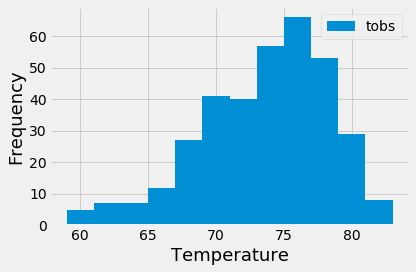

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year = dt.datetime.strptime(result, "%Y-%m-%d") - dt.timedelta(days=366)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.xlabel("Temperature",fontsize = 18, color = 'black')
plt.ylabel("Frequency",fontsize=18, color='black')
plt.tight_layout()
plt.savefig("Images/station-histogram.png")
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin_tavg_tmax  = calc_temps('2017-07-01','2017-07-14')
print(tmin_tavg_tmax)

[(69.0, 78.11627906976744, 87.0)]


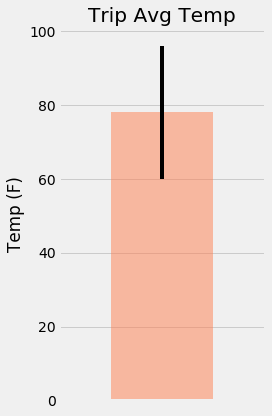

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame(tmin_tavg_tmax, columns=['tmin', 'tavg', 'tmax'])



trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/temperature.png")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


def precipitation(start_date, end_date):

    sel = [Station.station, 
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation, 
       func.sum(Measurement.prcp)]

    results = session.query(*sel).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[(77.0,), (77.0,), (80.0,), (80.0,), (75.0,), (73.0,), (78.0,), (77.0,), (78.0,), (80.0,), (80.0,), (78.0,), (78.0,), (78.0,), (73.0,), (74.0,), (80.0,), (79.0,), (77.0,), (80.0,), (76.0,), (79.0,), (75.0,), (79.0,), (78.0,), (79.0,), (78.0,), (78.0,), (76.0,), (74.0,), (77.0,), (78.0,), (79.0,), (79.0,), (77.0,), (80.0,), (78.0,), (78.0,), (78.0,), (77.0,), (79.0,), (79.0,), (79.0,), (79.0,), (75.0,), (76.0,), (73.0,), (72.0,), (71.0,), (77.0,), (79.0,), (78.0,), (79.0,), (77.0,), (79.0,), (77.0,), (78.0,), (78.0,), (78.0,), (78.0,), (77.0,), (74.0,), (75.0,), (76.0,), (73.0,), (76.0,), (74.0,), (77.0,), (76.0,), (76.0,), (74.0,), (75.0,), (75.0,), (75.0,), (75.0,), (71.0,), (63.0,), (70.0,), (68.0,), (67.0,), (77.0,), (74.0,), (77.0,), (76.0,), (76.0,), (75.0,), (76.0,), (75.0,), (73.0,), (75.0,), (73.0,), (75.0,), (74.0,), (75.0,), (74.0,), (75.0,), (73.0,), (75.0,), (73.0,), (73.0,), (74.0,), (70.0,), (72.0,), (70.0,), (67.0,), (67.0,), (69.0,), (70.0,), (68.0,), (69.0,), (69.0,), 

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-07'

# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


#daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()]
    
# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals

Aggregate Daily Normals for 07-01 to 07-14


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


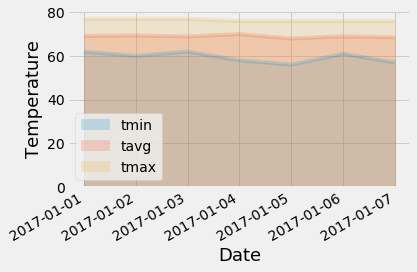

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True)
plt.tight_layout()
plt.savefig("Images/daily-normals.png")
plt.xlabel("Date",fontsize = 18, color = 'black')
plt.ylabel("Temperature",fontsize=18, color='black')
plt.show()